In [13]:
import os
import sys
import json
import pickle
from datetime import datetime
from random import randrange
import concurrent.futures

import numpy as np
import pandas as pd
import scipy

import librosa
import librosa.display
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    multilabel_confusion_matrix, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, Flatten, Dropout, 
    BatchNormalization, LSTM
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
)
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
data_df=pd.read_csv(r"data\combined.csv")
data_df1=pd.read_csv(r"data\combined.csv")


# Data Preparation

In [15]:
X = data_df.iloc[:, :-1].values
y = data_df['Labels'].values

#encoding
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(34527, 154) (34527, 6) (11509, 154) (11509, 6)


In [16]:
def plot_loss_accuracy_curves(history):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

# Function to calculate and display accuracy, precision, recall, F1 score, and ROC AUC
def display_metrics(model1, X_test, y_test):
    # Predict validation data
    y_test_pred = model1.predict(X_test)
    y_test_pred_class = (y_test_pred > 0.5).astype("int32")

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred_class)
    precision = precision_score(y_test, y_test_pred_class, average='weighted')
    recall = recall_score(y_test, y_test_pred_class, average='weighted')
    f1 = f1_score(y_test, y_test_pred_class, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred)

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

# Function to display confusion matrix for multilabel classification
def plot_confusion_matrix(model1, X_test, y_test):
    # Predict validation data
    y_test_pred = model1.predict(X_test)
    y_test_pred_class = (y_test_pred > 0.5).astype("int32")

    # Confusion Matrix
    cm = multilabel_confusion_matrix(y_test, y_test_pred_class)
    for i, matrix in enumerate(cm):
        plt.figure(figsize=(7, 5))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Label {i}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Function to plot ROC curve for multilabel classification
def plot_roc_curve(model1, X_test, y_test):
    y_test_pred = model1.predict(X_test)

    # Plot ROC curve for each label
    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_test_pred[:, i])
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for label {i}')
        plt.legend(loc='best')
        plt.show()

CNN

In [17]:

print("Checking for NaN/Inf values in data...")
print(f"X_train NaN count: {np.isnan(X_train).sum()}")
print(f"X_train Inf count: {np.isinf(X_train).sum()}")
print(f"y_train NaN count: {np.isnan(y_train).sum()}")

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

model2 = Sequential([
    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', 
           input_shape=(X_train.shape[1], 1)), 
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'), 
    
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'), 
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'), 
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'), 
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    
    Flatten(),
    Dense(64, activation='relu'),  
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='relu'), 
    Dropout(0.3),
    Dense(6, activation='softmax')
])

Checking for NaN/Inf values in data...
X_train NaN count: 2
X_train Inf count: 0
y_train NaN count: 0


In [18]:
model2.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. ENHANCED CALLBACKS
callback = [
    ReduceLROnPlateau(
        monitor='val_loss',  # Changed from 'loss' to 'val_loss'
        factor=0.4,          # Less aggressive reduction
        patience=3,          # More patience
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
]

In [19]:
history2=model2.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=callback)

Epoch 1/100
540/540 [==============================] - 114s 202ms/step - loss: 2.0725 - accuracy: 0.2381 - val_loss: 4.5933 - val_accuracy: 0.1739 - lr: 1.0000e-04
Epoch 2/100
540/540 [==============================] - 108s 199ms/step - loss: 1.7313 - accuracy: 0.2943 - val_loss: 1.5426 - val_accuracy: 0.3259 - lr: 1.0000e-04
Epoch 3/100
540/540 [==============================] - 108s 200ms/step - loss: 1.6069 - accuracy: 0.3360 - val_loss: 1.4321 - val_accuracy: 0.4145 - lr: 1.0000e-04
Epoch 4/100
540/540 [==============================] - 110s 203ms/step - loss: 1.5384 - accuracy: 0.3624 - val_loss: 1.3752 - val_accuracy: 0.4453 - lr: 1.0000e-04
Epoch 5/100
540/540 [==============================] - 133s 246ms/step - loss: 1.4740 - accuracy: 0.3902 - val_loss: 1.4971 - val_accuracy: 0.3847 - lr: 1.0000e-04
Epoch 6/100
132/540 [======>.......................] - ETA: 1:30 - loss: 1.4449 - accuracy: 0.4015

KeyboardInterrupt: 

In [ ]:
display_metrics(model2, X_test, y_test)

360/360 [==============================] - 8s 22ms/step
Accuracy: 0.5599
Precision: 0.8081
Recall: 0.5599
F1 Score: 0.6580
ROC AUC: 0.9303


In [29]:
model2.save("CNN_model.keras")

Hybrid CNN+LSTM model

In [10]:

from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, 
    CSVLogger, TensorBoard
)
from tensorflow.keras.regularizers import l2

model4 = Sequential([
    # CNN Feature Extraction Blocks
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', 
           input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu',
           kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    
    # LSTM Sequence Processing
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    
    # Dense Classification Layers
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(6, activation='softmax')
])

In [11]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list = [
    # Early Stopping - Prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    
    # Learning Rate Reduction
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    
    # Model Checkpointing - Save best model
    ModelCheckpoint(
        filepath='best_cnn_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    
    # CSV Logger - Save training history
    CSVLogger(
        filename='training_history.csv',
        separator=',',
        append=False
    ),
    
]
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=callbacks_list)

Epoch 1/100
 589/1079 [===============>..............] - ETA: 16s - loss: nan - accuracy: 0.1898

KeyboardInterrupt: 

In [3]:
display_metrics(model4, X_test, y_test)

NameError: name 'display_metrics' is not defined

In [2]:
model4.save("CNN_LSTM_model.keras")

NameError: name 'model4' is not defined

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Dropout, 
    BatchNormalization, Attention, MultiHeadAttention,
    GlobalAveragePooling1D, Add, LayerNormalization, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np

# Enhanced CNN with Skip Connections and Attention (No LSTM)
def create_enhanced_cnn_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape, name='input')
    
    # First Conv Block
    x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', 
               kernel_regularizer=l2(0.001), name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool1')(x)
    
    # Store for skip connection
    skip1 = x
    
    # Second Conv Block
    x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool2')(x)
    
    # Skip connection 1 (match dimensions properly)
    skip1_resized = MaxPooling1D(pool_size=2, strides=2, padding='same', name='skip1_pool')(skip1)
    x = Add(name='skip_add1')([x, skip1_resized])
    
    # Store for another skip connection
    skip2 = x
    
    # Third Conv Block
    x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool3')(x)
    x = Dropout(0.3, name='dropout1')(x)
    
    # Fourth Conv Block
    x = Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu',
               kernel_regularizer=l2(0.001), name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same', name='pool4')(x)
    
    # Skip connection 2 (match dimensions and channels)
    skip2_resized = Conv1D(32, kernel_size=1, strides=1, padding='same', name='skip2_conv')(skip2)
    skip2_resized = MaxPooling1D(pool_size=4, strides=4, padding='same', name='skip2_pool')(skip2_resized)
    x = Add(name='skip_add2')([x, skip2_resized])
    
    # Multi-head attention
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        dropout=0.3,
        name='multihead_attention'
    )(x, x)
    
    # Residual connection with attention
    x = Add(name='attention_residual')([x, attention_output])
    x = LayerNormalization(name='layer_norm')(x)
    
    # Global pooling instead of flatten for better feature extraction
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001), name='dense1')(x)
    x = BatchNormalization(name='bn_dense1')(x)
    x = Dropout(0.4, name='dropout2')(x)
    
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001), name='dense2')(x)
    x = Dropout(0.3, name='dropout3')(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='Enhanced_CNN_Skip_Attention')
    
    return model


Model: "Enhanced_CNN_Skip_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 154, 1)]             0         []                            
                                                                                                  
 conv1 (Conv1D)              (None, 154, 128)             768       ['input[0][0]']               
                                                                                                  
 bn1 (BatchNormalization)    (None, 154, 128)             512       ['conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling1D)        (None, 77, 128)              0         ['bn1[0][0]']                 
                                                                        

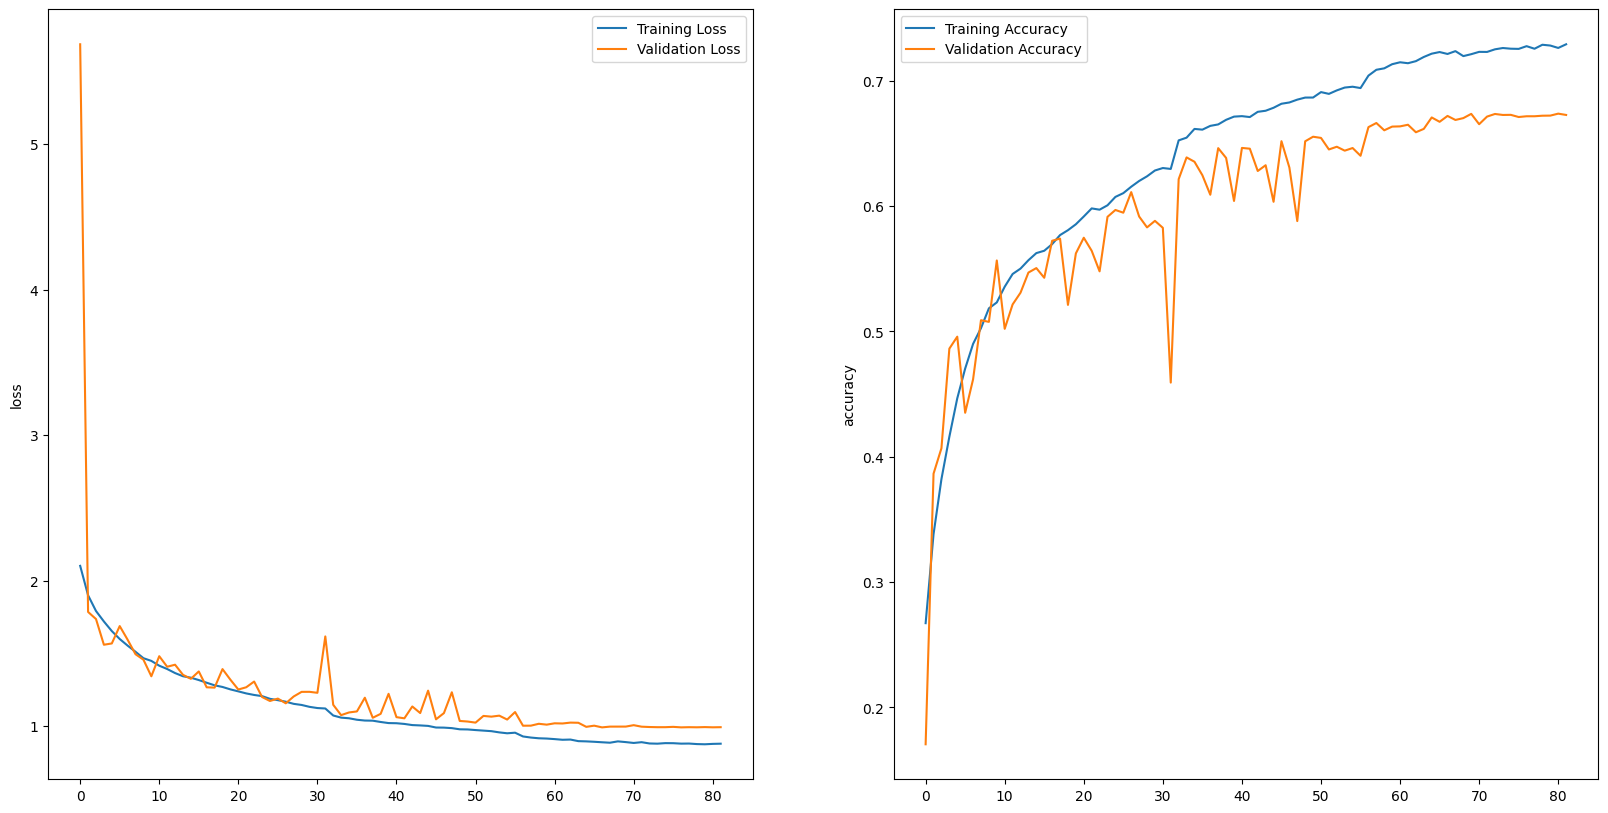

In [23]:

# Create the model using your data shape
model_enhanced = create_enhanced_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=6)

# Compile model
model_enhanced.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_enhanced.summary()

# Enhanced callbacks
callbacks_enhanced = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        filepath='best_enhanced_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
]

# Train the model
print("Training Enhanced CNN with Skip Connections and Attention...")
history_enhanced = model_enhanced.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=callbacks_enhanced,
    verbose=1
)

# Display metrics
print("\nEvaluating Enhanced CNN Model:")
display_metrics(model_enhanced, X_test, y_test)

# Save the final model
model_enhanced.save("Enhanced_CNN_Skip_Attention_model.keras")

# Plot training history
plot_loss_accuracy_curves(history_enhanced)

In [492]:
def compile_residual_model(model, learning_rate=0.001):
    """Compile model with advanced optimization settings"""
    
    # Use AdamW optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compile with label smoothing
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Use label smoothing in training
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model


def get_advanced_callbacks(model_name, learning_rate=0.001):
    """Get advanced callbacks for better training"""
    
    callbacks = [
        # Early stopping with more patience for complex model
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        
        # Cosine annealing learning rate schedule
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: learning_rate * 0.5 * (1 + np.cos(epoch * np.pi / 100))
        ),
        
        # Reduce LR on plateau as backup
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name.lower()}_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        )
    ]
    
    return callbacks

In [493]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

def compile_model(model, learning_rate=0.001):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            CategoricalAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

def get_callbacks(model_name, patience=15):
    """Get training callbacks"""
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(save_dir, f'{model_name}_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks_list

In [494]:
def train_model(model, X_train, y_train, X_val, y_val, 
               model_name, epochs=100, batch_size=32):
    """Train a single model with early stopping"""
    global models_dict, histories
    
    print(f"\n{'='*60}")
    print(f"Training {model_name} Model")
    print(f"{'='*60}")
    
    # Print model summary
    print(f"\nModel Architecture:")
    model.summary()
    
    callbacks_list=get_callbacks(model_name)
    
    print(f"Using callbacks: Early Stopping (patience=10), Reduce LR on Plateau")
    
    # Train model
    start_time = datetime.now()
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = datetime.now() - start_time
    actual_epochs = len(history.history['loss'])
    
    print(f"\nTraining completed in: {training_time}")
    print(f"Actual epochs trained: {actual_epochs}/{epochs}")
    
    if actual_epochs < epochs:
        print(f"Early stopping triggered - stopped {epochs - actual_epochs} epochs early")
    
    # Store model and history
    models_dict[model_name] = model
    histories[model_name] = history
    
    return model, history


In [495]:
def plot_training_history(history, model_name):
    """Plot training history"""
    
    if history is None:
        print(f"No history found for {model_name}")
        return
    
    # Handle both history object and dictionary
    if hasattr(history, 'history'):
        history_dict = history.history
    else:
        history_dict = history
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=16)
    
    # Accuracy
    if 'accuracy' in history_dict:
        axes[0, 0].plot(history_dict['accuracy'], label='Training')
        if 'val_accuracy' in history_dict:
            axes[0, 0].plot(history_dict['val_accuracy'], label='Validation')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
    
    # Loss
    if 'loss' in history_dict:
        axes[0, 1].plot(history_dict['loss'], label='Training')
        if 'val_loss' in history_dict:
            axes[0, 1].plot(history_dict['val_loss'], label='Validation')
        axes[0, 1].set_title('Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # Precision
    if 'precision' in history_dict:
        axes[1, 0].plot(history_dict['precision'], label='Training')
        if 'val_precision' in history_dict:
            axes[1, 0].plot(history_dict['val_precision'], label='Validation')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Recall
    if 'recall' in history_dict:
        axes[1, 1].plot(history_dict['recall'], label='Training')
        if 'val_recall' in history_dict:
            axes[1, 1].plot(history_dict['val_recall'], label='Validation')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    # Save plot if save_dir exists
    try:
        plt.savefig(os.path.join(save_dir, f'{model_name}_training_history.png'), 
                   dpi=300, bbox_inches='tight')
    except:
        pass  # Skip saving if save_dir doesn't exist
        
    plt.show()

In [496]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    """Plot confusion matrix"""
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Handle different label formats
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        # One-hot encoded labels
        y_test_labels = np.argmax(y_test, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        # Integer labels
        y_test_labels = y_test
        y_pred_labels = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    
    # Generate class names
    unique_labels = np.unique(y_test_labels)
    class_names = [f'Class {i}' for i in unique_labels]
    
    # Try to use label_encoder if it exists globally
    try:
        global label_encoder
        if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
            class_names = label_encoder.classes_
    except:
        pass
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Save plot if save_dir exists
    try:
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'), 
                   dpi=300, bbox_inches='tight')
    except:
        pass  # Skip saving if save_dir doesn't exist
        
    plt.show()

In [497]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    global results, label_encoder
    
    print(f"\n{'='*40}")
    print(f"Evaluating {model_name}")
    print(f"{'='*40}")
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Classification report
    class_names = label_encoder.classes_
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return accuracy, report


In [498]:
def save_results():
    """Save all training results"""
    global models_dict, label_encoder, scaler, results
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save models
    for model_name, model in models_dict.items():
        model.save(os.path.join(save_dir, f'{model_name}_{timestamp}.h5'))
    
    # Save other objects
    with open(os.path.join(save_dir, f'label_encoder_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)
    
    with open(os.path.join(save_dir, f'scaler_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    
    with open(os.path.join(save_dir, f'results_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    print(f"\nAll results saved with timestamp: {timestamp}")


In [499]:
def train_individual_model(X_train, X_val, X_test, y_train, y_val, y_test, 
                          input_shape, num_classes, model_type='CNN', 
                          epochs=100, batch_size=32):
    """
    Trains a model based on the specified model_type using pre-prepared data.
    
    Parameters:
        X_train, X_val, X_test: Training, validation, and test features
        y_train, y_val, y_test: Training, validation, and test labels
        input_shape: Shape of input features
        num_classes: Number of output classes
        model_type (str): One of 'CNN', 'LSTM', 'CNN_LSTM', 'ResidualCNN'
        epochs (int): Number of training epochs
        batch_size (int): Size of each training batch
        
    Returns:
        model: Trained model
        history: Training history
        accuracy: Test accuracy
    """
    model_type = model_type.upper()
    print(f"Training {model_type} model...")

    # Select and create the appropriate model
    if model_type == 'CNN':
        model = create_cnn_model(input_shape, num_classes, model_type)
    elif model_type == 'LSTM':
        model = create_lstm_model(input_shape, num_classes, model_type)
    elif model_type == 'CNN_LSTM':
        model = create_cnn_lstm_model(input_shape, num_classes, model_type)
    elif model_type == 'RESIDUALCNN':
        model = create_residual_cnn_model(input_shape, num_classes, model_type)
    else:
        raise ValueError("Invalid model_type. Choose from 'CNN', 'LSTM', 'CNN_LSTM', 'ResidualCNN'.")

    # Compile and train the model
    model = compile_model(model)
    model, history = train_model(model, X_train, y_train, X_val, y_val, 
                                model_type, epochs, batch_size)

    # Evaluate
    accuracy, report = evaluate_model(model, X_test, y_test, model_type)

    # Plot (pass the history object to plotting functions)
    plot_training_history(history, model_type)
    plot_confusion_matrix(model, X_test, y_test, model_type)

    return model, history, accuracy


In [500]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
# X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your CNN model - now passing all required parameters
cnn_model, cnn_history, cnn_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='CNN'
)

# Optional: Save all results
# save_results()

print(f"CNN Model Accuracy: {cnn_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training CNN model...

Training CNN Model

Model Architecture:
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 166, 1)            0         
                                                                 
 conv1d_82 (Conv1D)          (None, 166, 64)           256       
                                                                 
 batch_normalization_83 (Ba  (None, 166, 64)           256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 83, 64)            0         
 ng1D)                                                           
             

KeyboardInterrupt: 

Preparing data for training...
Training set: (8056, 57)
Validation set: (1151, 57)
Test set: (2302, 57)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training CNN model...

Training CNN Model

Model Architecture:
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 57, 1)             0         
                                                                 
 conv1d_27 (Conv1D)          (None, 57, 64)            256       
                                                                 
 batch_normalization_27 (Ba  (None, 57, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 28, 64)            0         
 ng1D)                                                           
                

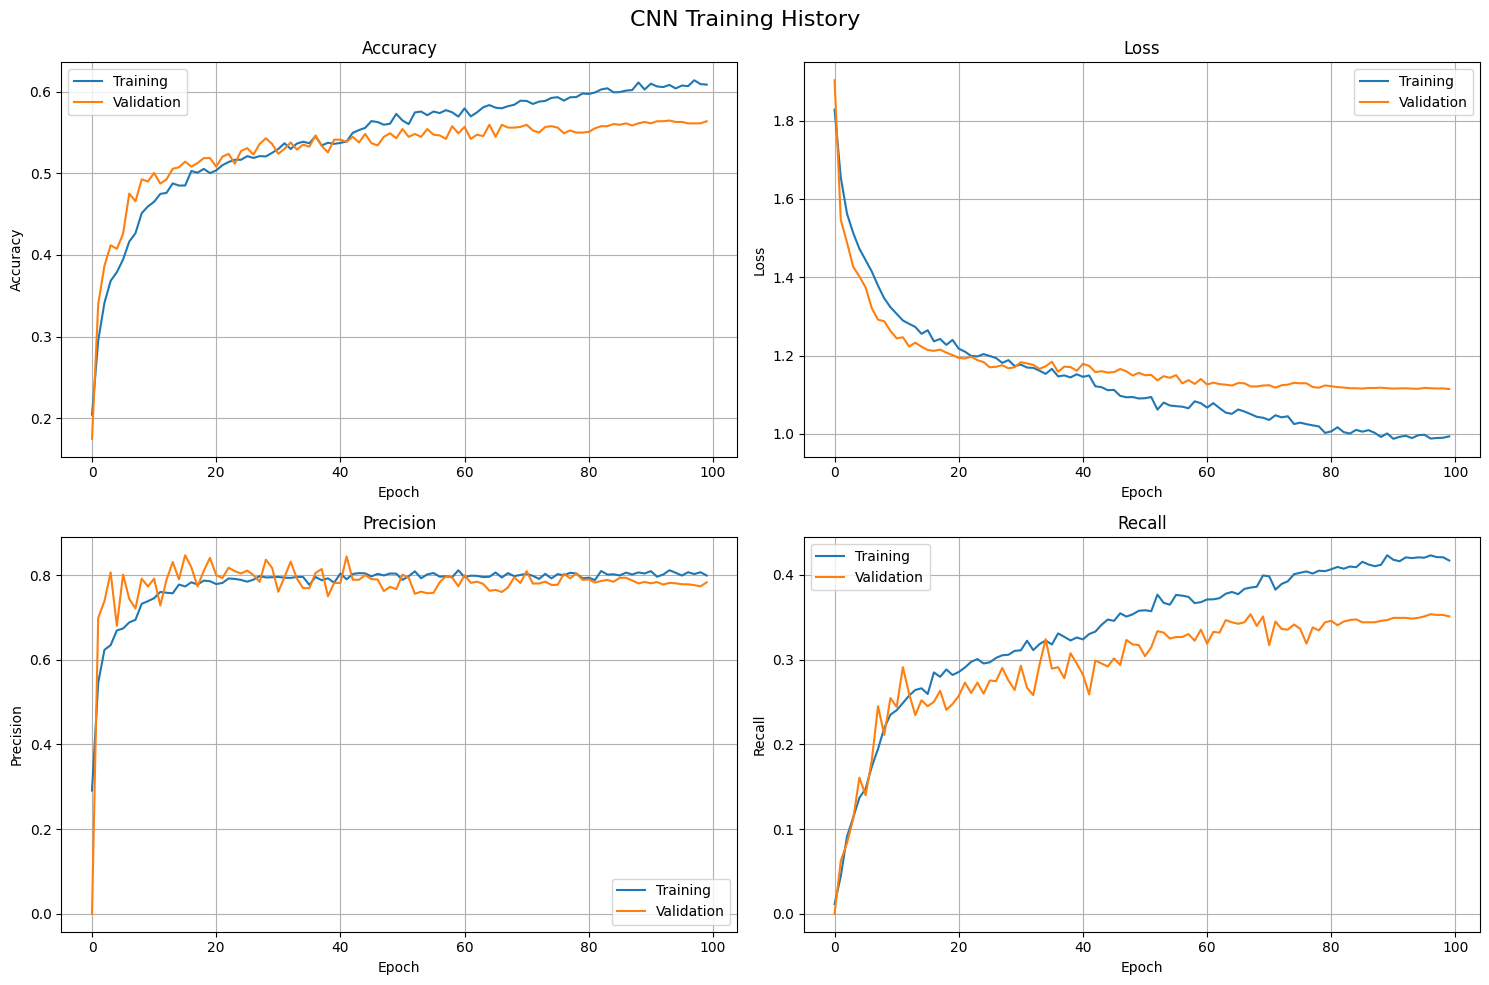

72/72 [==============================] - 0s 3ms/step


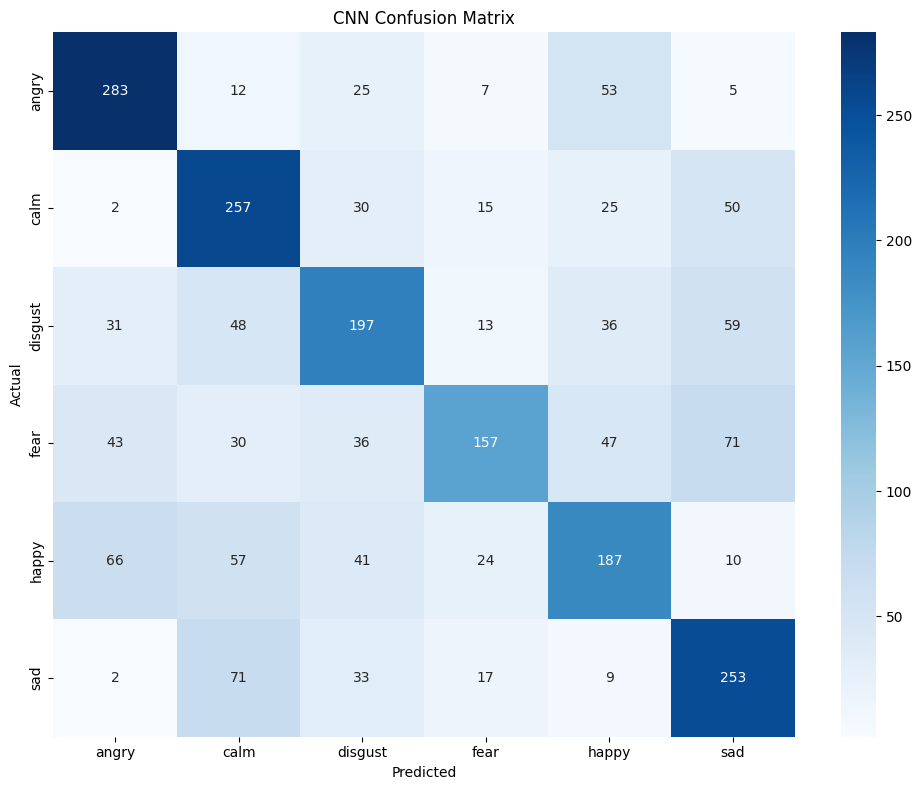

CNN Model Accuracy: 0.5795


In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
#X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your CNN model - now passing all required parameters
cnn_model, cnn_history, cnn_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='CNN'
)

# Optional: Save all results
# save_results()

print(f"CNN Model Accuracy: {cnn_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training LSTM model...

Training LSTM Model

Model Architecture:
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 166, 1)            0         
                                                                 
 lstm_3 (LSTM)               (None, 166, 128)          66560     
                                                                 
 batch_normalization_33 (Ba  (None, 166, 128)          512       
 tchNormalization)                                               
                                                                 
 lstm_4 (LSTM)               (None, 166, 64)           49408     
                                                                 
 batch_nor

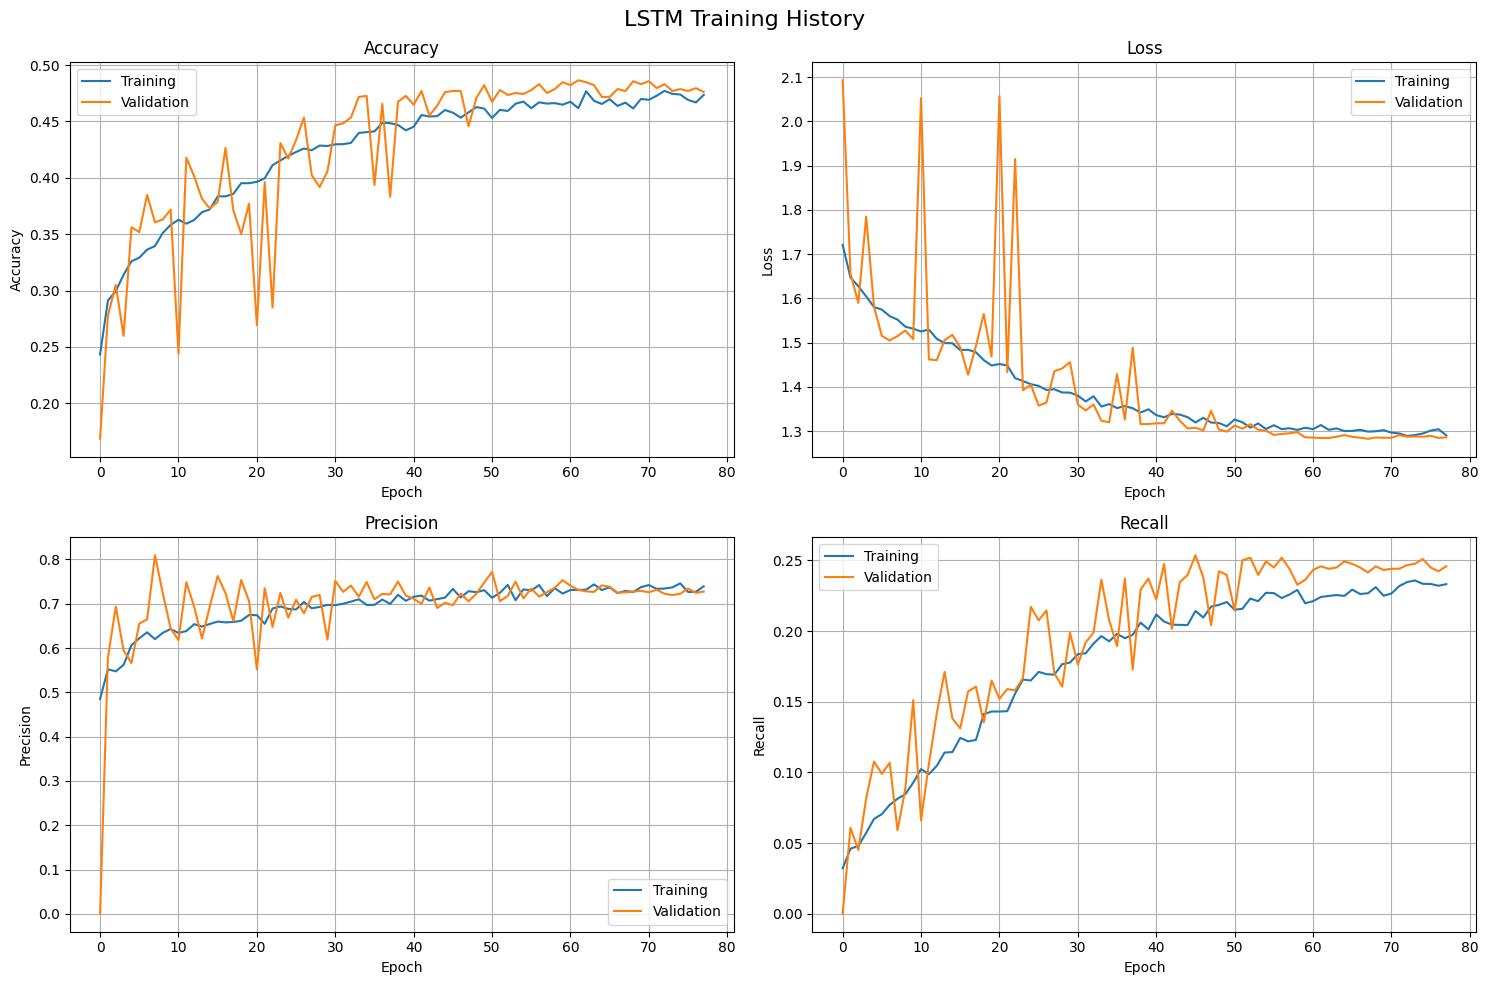

72/72 [==============================] - 3s 44ms/step


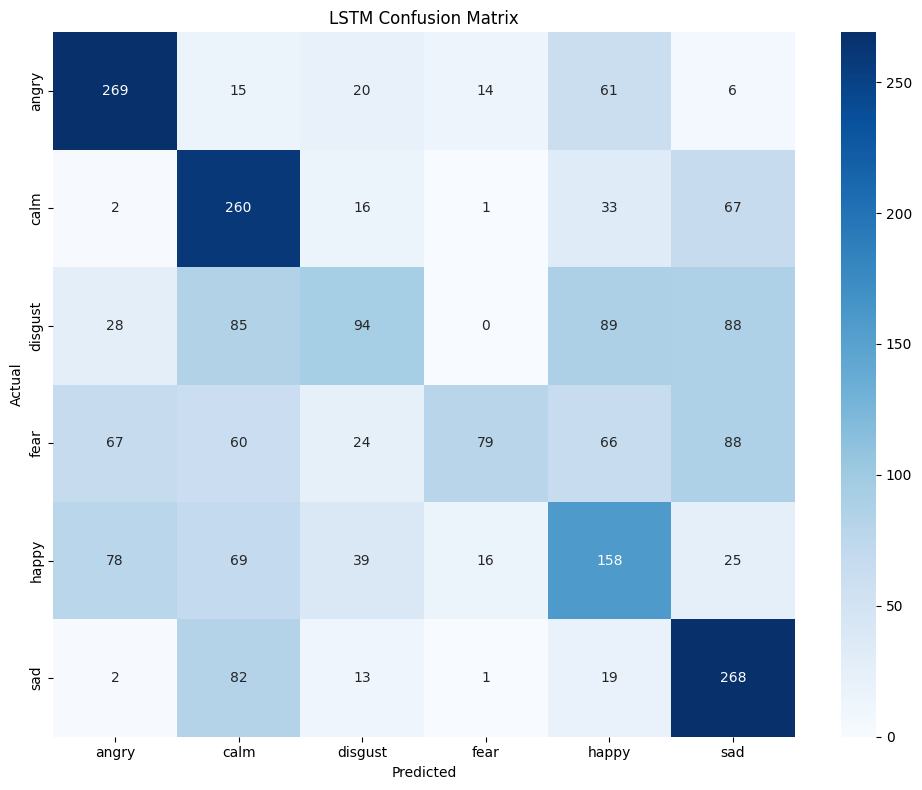

LSTM Model Accuracy: 0.4900


In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
#X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your LSTM model - now passing all required parameters
lstm_model, lstm_history, lstm_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='LSTM'
)

# Optional: Save all results
# save_results()

print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
#X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your LSTM model - now passing all required parameters
lstm_model, lstm_history, lstm_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='RESIDUALCNN'
)

# Optional: Save all results
# save_results()

print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training RESIDUALCNN model...

Training RESIDUALCNN Model

Model Architecture:
Model: "RESIDUALCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 reshape_15 (Reshape)        (None, 166, 1)               0         ['input_2[0][0]']             
                                                                                                  
 conv1d_50 (Conv1D)          (None, 166, 64)              1024      ['reshape_15[0][0]']          
                      

KeyboardInterrupt: 